# OneStopEnglish BERT and RoBERTa Models

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel

In [3]:
max_length = 100
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 32

In [4]:
df = pd.read_csv("../onestopec.csv")

In [5]:
df['labels'] = df['labels'].apply(lambda x: x-1)

In [6]:
text = df['text']
labels = df['labels']

In [7]:
train_df, test_df = train_test_split(df, test_size=.1, shuffle=True)

In [8]:
len(train_df)

6657

In [9]:
valid_df = train_df.iloc[:600].copy()
train_df = train_df.iloc[600:]

## BERT Trainable

In [30]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

#tokenize text data for each split
train_encodings = bert_tokenizer([str(t) for t in train_df["text"].tolist()], truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
valid_encodings = bert_tokenizer([str(t) for t in valid_df["text"].tolist()], truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
test_encodings = bert_tokenizer([str(t) for t in test_df["text"].tolist()], truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'token_type_ids': encodings['token_type_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))
    return dataset

#create TF datasest with encoding and labels
train_dataset = create_dataset(train_encodings, train_df['labels'])
valid_dataset = create_dataset(valid_encodings, valid_df['labels'])
test_dataset = create_dataset(test_encodings, test_df['labels'])

#batching
train_dataset = train_dataset.shuffle(len(train_df)).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [31]:
def create_bert_classification_model(bert_model, num_classes=3, num_train_layers=0, hidden_size=200, dropout=0.5, learning_rate=0.00005):
    if num_train_layers == 0:
        bert_model.trainable = False
    elif num_train_layers == 12:
        bert_model.trainable = True
    else:
        retrain_layers = ['_' + str(11 - i) for i in range(num_train_layers)]
        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

    bert_inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
    bert_out = bert_model(bert_inputs)
    pooler_token = bert_out[1]
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics=['accuracy'])
    return classification_model

In [23]:
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

In [24]:
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]',          

In [25]:
bert_classification_model_history = bert_classification_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=1,
)

2024-07-20 17:55:18.166539: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-20 17:55:18.171762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - ETA: 0s - loss: 0.8133 - accuracy: 0.6166

2024-07-20 17:59:05.047867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - 245s 1s/step - loss: 0.8133 - accuracy: 0.6166 - val_loss: 0.5185 - val_accuracy: 0.7850


In [64]:
preds = bert_classification_model.predict(test_dataset)
preds = tf.argmax(preds, axis=-1)
print(classification_report(test_df['labels'], preds.numpy()))

24/24 [==============================] - 21s 838ms/step
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       222
           1       0.71      0.96      0.82       267
           2       0.89      0.54      0.67       251

    accuracy                           0.75       740
   macro avg       0.77      0.74      0.74       740
weighted avg       0.77      0.75      0.74       740



In [69]:
bert_classification_model.evaluate(test_dataset)

24/24 [==============================] - 16s 614ms/step - loss: 0.5613 - accuracy: 0.7473


[0.5613001585006714, 0.7472972869873047]

In [65]:
cm = tf.math.confusion_matrix(test_df['labels'], preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

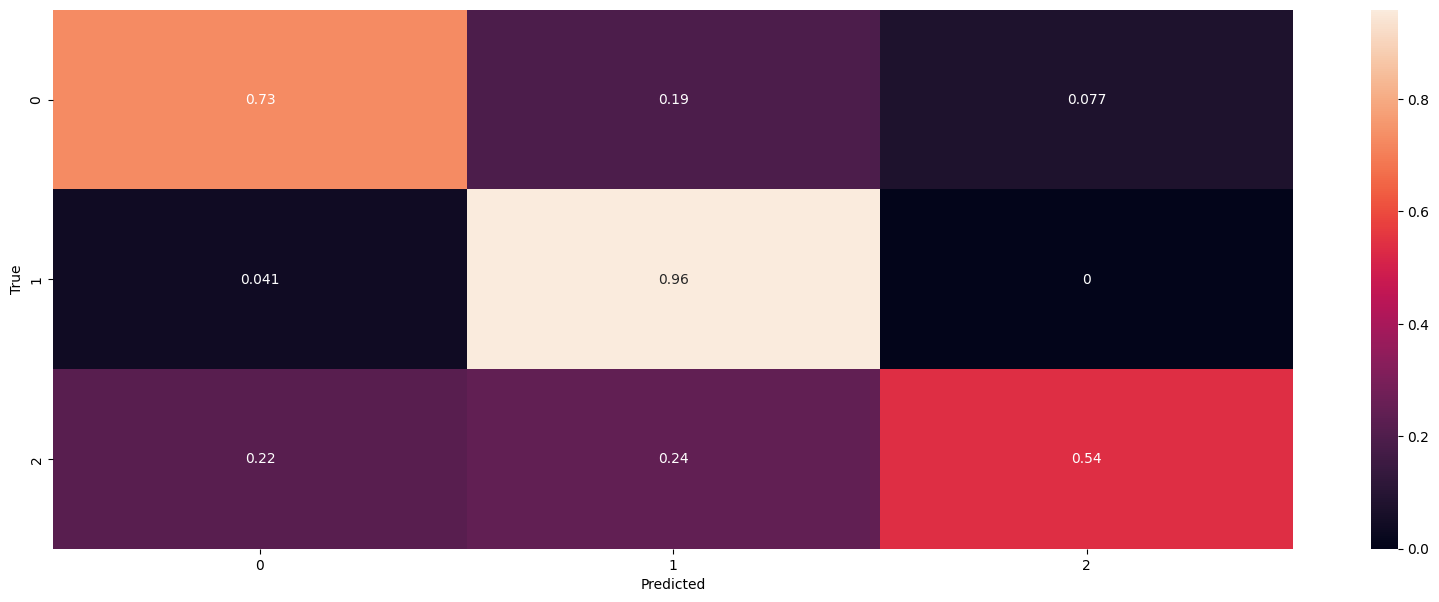

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

## BERT Untrainable

In [32]:
bert_classification_model_ut = create_bert_classification_model(bert_model, num_train_layers=0)

In [33]:
bert_classification_model_ut_history = bert_classification_model_ut.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=5,
)

Epoch 1/5


2024-07-20 20:19:47.048864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - ETA: 0s - loss: 1.1691 - accuracy: 0.3667

2024-07-20 20:21:19.010142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - 119s 561ms/step - loss: 1.1691 - accuracy: 0.3667 - val_loss: 1.0583 - val_accuracy: 0.4350
Epoch 2/5
190/190 [==============================] - 76s 398ms/step - loss: 1.0894 - accuracy: 0.3951 - val_loss: 1.0478 - val_accuracy: 0.4417
Epoch 3/5
190/190 [==============================] - 75s 393ms/step - loss: 1.0672 - accuracy: 0.4169 - val_loss: 1.0312 - val_accuracy: 0.4433
Epoch 4/5
190/190 [==============================] - 76s 400ms/step - loss: 1.0585 - accuracy: 0.4345 - val_loss: 1.0415 - val_accuracy: 0.4550
Epoch 5/5
190/190 [==============================] - 75s 392ms/step - loss: 1.0439 - accuracy: 0.4448 - val_loss: 1.0252 - val_accuracy: 0.4583


In [34]:
preds = bert_classification_model_ut.predict(test_dataset)
preds = tf.argmax(preds, axis=-1)
print(classification_report(test_df['labels'], preds.numpy()))

2024-07-20 20:26:45.382695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 27s 844ms/step
              precision    recall  f1-score   support

           0       0.62      0.02      0.04       224
           1       0.45      0.78      0.57       255
           2       0.51      0.56      0.53       261

    accuracy                           0.47       740
   macro avg       0.53      0.46      0.38       740
weighted avg       0.52      0.47      0.40       740



In [36]:
bert_classification_model_ut.evaluate(test_dataset)

24/24 [==============================] - 14s 582ms/step - loss: 1.0184 - accuracy: 0.4743


[1.0184296369552612, 0.4743243157863617]

Text(220.72222222222223, 0.5, 'True')

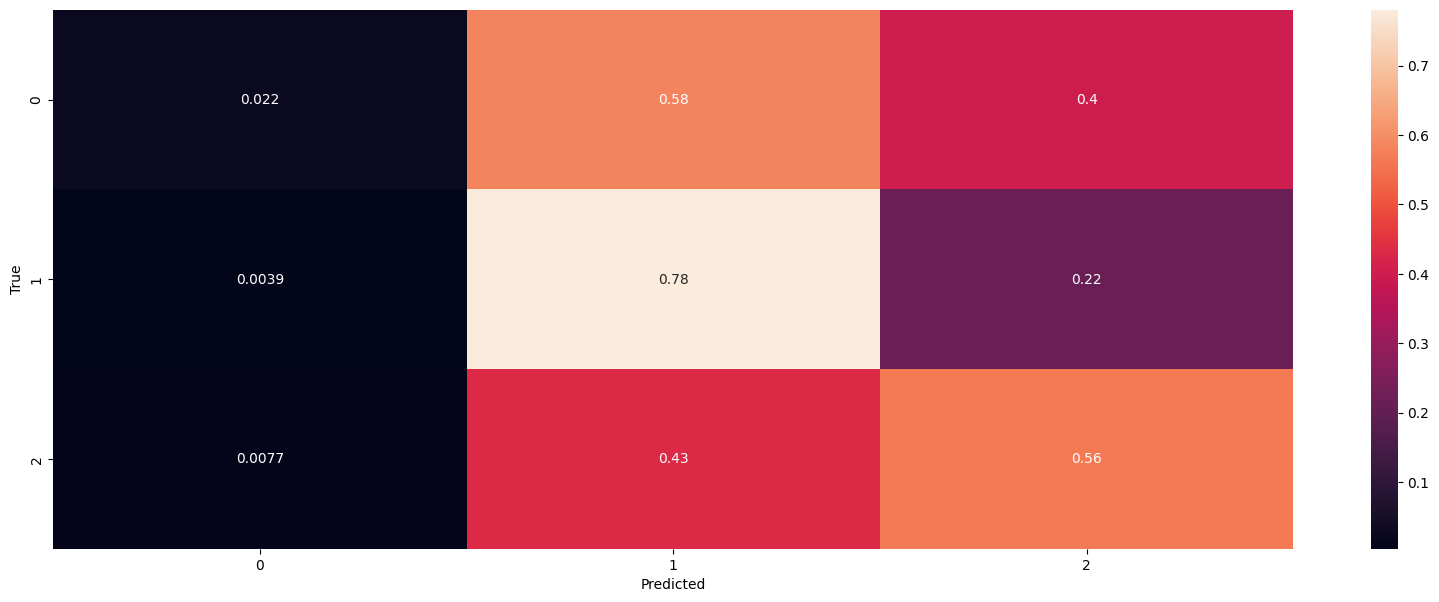

In [37]:
cm = tf.math.confusion_matrix(test_df['labels'], preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

## RoBERTa

In [10]:
rtokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

train_encodings = rtokenizer([str(t) for t in train_df["text"].tolist()], truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = rtokenizer([str(t) for t in valid_df["text"].tolist()], truncation=True, padding=True, max_length=max_length, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, train_df['labels']))
train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, valid_df['labels']))
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

2024-07-20 21:03:03.561120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-20 21:03:03.561388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [11]:
def create_roberta_cl_model(model,
                         num_classes = 3,
                         dropout=0.3,
                         learning_rate=0.00005):
    """
    """
    model.trainable = True

    #tf.keras.mixed_precision.set_global_policy('mixed_float16')

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(300,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    model_inputs = [input_ids, attention_mask]
    model_out = model(input_ids=input_ids, attention_mask=attention_mask)

    model_out = model_out.last_hidden_state

    conv = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(model_out)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    lstm = tf.keras.layers.LSTM(units=256, return_sequences=False, return_state=False)(conv)
    lstm = tf.keras.layers.Dropout(dropout)(lstm)
    # dense = tf.keras.layers.Dense(256, activation='relu')(lstm)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(lstm)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.1)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [12]:
roberta_cl_model = create_roberta_cl_model(model=roberta_model, num_classes=6)

In [13]:
roberta_cl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                           

In [14]:
roberta_cl_model_history = roberta_cl_model.fit(train_dataset,
                                      validation_data=valid_dataset,
                                      epochs=5)

Epoch 1/5


2024-07-20 18:29:43.151298: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-20 18:29:43.167035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-20 18:29:48.468950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-20 18:29:48.829704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.6858

2024-07-20 18:40:55.079975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-20 18:41:00.473063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - 698s 4s/step - loss: 0.6690 - accuracy: 0.6858 - val_loss: 0.5938 - val_accuracy: 0.7150
Epoch 2/5
190/190 [==============================] - 708s 4s/step - loss: 0.4938 - accuracy: 0.7864 - val_loss: 0.3938 - val_accuracy: 0.8367
Epoch 3/5
190/190 [==============================] - 685s 4s/step - loss: 0.3300 - accuracy: 0.8732 - val_loss: 0.3874 - val_accuracy: 0.8450
Epoch 4/5
190/190 [==============================] - 680s 4s/step - loss: 0.2049 - accuracy: 0.9290 - val_loss: 0.5098 - val_accuracy: 0.8467
Epoch 5/5
190/190 [==============================] - 626s 3s/step - loss: 0.1027 - accuracy: 0.9676 - val_loss: 0.6230 - val_accuracy: 0.8650


In [15]:
test_encodings = rtokenizer([str(t) for t in test_df["text"].tolist()], truncation=True, padding=True, max_length=max_length, return_tensors='tf')
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, test_df['labels']))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
preds = roberta_cl_model.predict(tdataset)
preds = tf.argmax(preds, axis=-1)
print(classification_report(test_df['labels'], preds.numpy()))

2024-07-20 19:26:16.032615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-20 19:26:23.343384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 25s 713ms/step
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       211
           1       0.93      0.90      0.91       252
           2       0.85      0.83      0.84       277

    accuracy                           0.84       740
   macro avg       0.83      0.83      0.83       740
weighted avg       0.84      0.84      0.84       740



In [17]:
cm = tf.math.confusion_matrix(test_df['labels'], preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

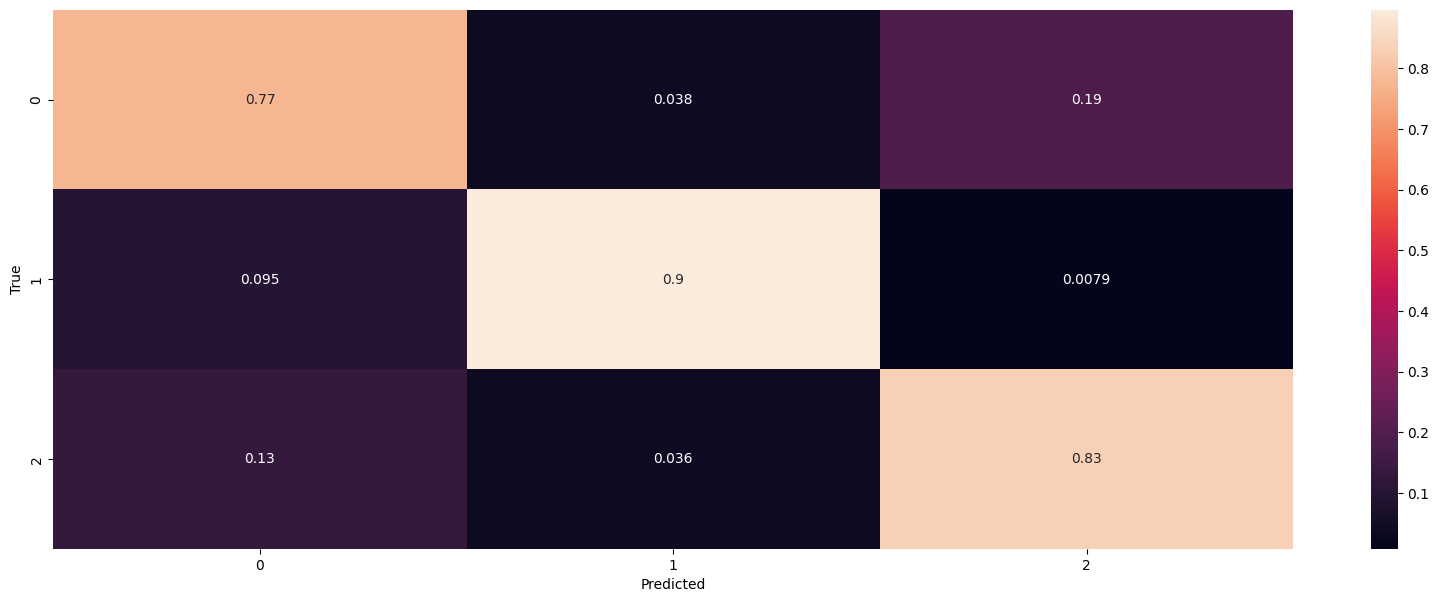

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

In [19]:
roberta_cl_model.evaluate(tdataset)

24/24 [==============================] - 12s 504ms/step - loss: 0.7448 - accuracy: 0.8378


[0.744783878326416, 0.837837815284729]

## RoBERTa + GRU

In [14]:
def create_roberta_gru_model(model,
                         num_classes = 6,
                         dropout=0.3,
                         learning_rate=0.0001):
    """
    """
    model.trainable = False

    #tf.keras.mixed_precision.set_global_policy('mixed_float16')

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(300,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    model_inputs = [input_ids, attention_mask]
    model_out = model(input_ids=input_ids, attention_mask=attention_mask)

    model_out = model_out.last_hidden_state

    conv = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(model_out)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    gru = tf.keras.layers.GRU(256)(conv)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(gru)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.1)
    #optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [15]:
roberta_gru_model = create_roberta_gru_model(model=roberta_model, num_classes=6)

In [16]:
roberta_gru_model_history = roberta_gru_model.fit(train_dataset,
                                      validation_data=valid_dataset,
                                      epochs=5)

Epoch 1/5


2024-07-20 21:23:43.626609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-20 21:23:52.734887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-20 21:23:53.308871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - ETA: 0s - loss: 1.1297 - accuracy: 0.3368

2024-07-20 21:25:24.846191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-20 21:25:29.363874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - 128s 596ms/step - loss: 1.1297 - accuracy: 0.3368 - val_loss: 1.1168 - val_accuracy: 0.2767
Epoch 2/5
190/190 [==============================] - 83s 437ms/step - loss: 1.1089 - accuracy: 0.3434 - val_loss: 1.1173 - val_accuracy: 0.2767
Epoch 3/5
190/190 [==============================] - 81s 425ms/step - loss: 1.1064 - accuracy: 0.3493 - val_loss: 1.1194 - val_accuracy: 0.2767
Epoch 4/5
161/190 [========================>.....] - ETA: 11s - loss: 1.1048 - accuracy: 0.3527

KeyboardInterrupt: 